In [ ]:
!pip install NLTK
!pip install spaCy
!pip install tiktoken

In [1]:
import nltk
nltk.download('punkt')
import spacy
import re
import tiktoken
import kagglehub
import pandas as pd
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load datasets

## COVID

In [2]:
path = kagglehub.dataset_download("elvinagammed/covid19-fake-news-dataset-nlp")

100%|██████████| 1.67M/1.67M [00:00<00:00, 108MB/s]

Extracting files...


In [3]:
files = os.listdir(path)
print(files)

['Constraint_Test.xlsx', 'Constraint_Train.csv', 'english_test_with_labels.csv', 'Constraint_Val.csv', 'Constraint_Test.csv', 'Constraint_Train.xlsx', 'test_ernie2.0_results.csv']


In [4]:
# Train data
# ONLY TRAIN DATA WILL BE TAKEN FOR THE PROJECT
csv_file = f"{path}/Constraint_Train.csv"
covid_train = pd.read_csv(csv_file, encoding='latin-1')
covid_train = covid_train[['tweet', 'label']]
covid_train.label.value_counts()

,count
label,
real,3360
fake,3060


In [5]:
# Test data - NOT USED
#csv_file = f"{path}/english_test_with_labels.csv"  # החלף בשם הקובץ האמיתי
#covid_test = pd.read_csv(csv_file, encoding='latin-1')
#covid_test = covid_test[['tweet', 'label']]
#covid_test.label.value_counts()

In [6]:
# Validation data _ NOT USED
#csv_file = f"{path}/Constraint_Val.csv"
#covid_val = pd.read_csv(csv_file, encoding='latin-1')
#covid_val = covid_val[['tweet', 'label']]
#covid_val.shape

In [7]:
#covid_all = pd.concat([covid_train,covid_test,covid_val], ignore_index=True)
covid_all = covid_train
covid_all['label'] = ['false' if (str(i) == 'fake') else 'true' if (str(i) == 'real') else str(i) for i in covid_all.label]
covid_all.columns = ['claim', 'label']
covid_all.label.value_counts(normalize=True)

,proportion
label,
true,0.523364
false,0.476636


## Pubhealth

In [8]:
path = kagglehub.dataset_download("ersindemirel/pubhealthdataset")
print("Path to dataset files:", path)

100%|██████████| 21.6M/21.6M [00:00<00:00, 139MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ersindemirel/pubhealthdataset/versions/1


In [9]:
files = os.listdir(path)
print(files)

['train.tsv', 'test.tsv']


In [10]:
# Train data
csv_file = f"{path}/train.tsv"
pubhealth_train = pd.read_csv(csv_file, sep='\t')
pubhealth_train = pubhealth_train[pubhealth_train.label.isin(['false', 'true'])]
pubhealth_train.label.value_counts()

,count
label,
true,5078
false,3001


In [11]:
# Test data
csv_file = f"{path}/test.tsv"
pubhealth_test = pd.read_csv(csv_file, sep='\t')
pubhealth_test = pubhealth_test[pubhealth_test.label.isin(['false', 'true'])]
pubhealth_test.label.value_counts()

,count
label,
true,599
false,388


In [12]:
pubhealth_all = pd.concat([pubhealth_train,pubhealth_test], ignore_index=True)
pubhealth_all = pubhealth_all[['claim', 'label']]
pubhealth_all.label.value_counts(normalize=True)

,proportion
label,
true,0.626186
false,0.373814


## Misinformation-Detection

In [13]:
!git clone https://github.com/HLR/Misinformation-Detection.git

Cloning into 'Misinformation-Detection'...
remote: Enumerating objects: 833, done.
remote: Counting objects: 100% (833/833), done.
remote: Compressing objects: 100% (506/506), done.
remote: Total 833 (delta 326), reused 824 (delta 322), pack-reused 0 (from 0)
Receiving objects: 100% (833/833), 6.31 MiB | 20.70 MiB/s, done.
Resolving deltas: 100% (326/326), done.


In [14]:
misinfo_xlsx = ['/content/Misinformation-Detection/data/all.xlsx','/content/Misinformation-Detection/data/all_article.xlsx',
       '/content/Misinformation-Detection/data/test.xlsx','/content/Misinformation-Detection/data/test_article.xlsx',
       '/content/Misinformation-Detection/data/train.xlsx','/content/Misinformation-Detection/data/train_article.xlsx']
misinfo_csv = ['/content/Misinformation-Detection/data/test_article_data_high.csv','/content/Misinformation-Detection/data/test_article_data_low.csv',
        '/content/Misinformation-Detection/data/test_article_data_none.csv','/content/Misinformation-Detection/data/train_article_data_high.csv',
        '/content/Misinformation-Detection/data/train_article_data_low.csv','/content/Misinformation-Detection/data/train_article_data_none.csv']



In [15]:
def csv(file):
  d = pd.read_csv(file)
  d = d[['claim', 'label']]
  return d

def xlsx(file):
  d = pd.read_excel(file)
  d = d[['claim', 'claim_label']]
  d.columns = ['claim', 'label']
  return d

gg = []
for i in misinfo_xlsx:
  g = xlsx(i)
  gg.append(g)

for i in misinfo_csv:
  g = csv(i)
  gg.append(g)

In [16]:
misinfo = pd.concat(gg, ignore_index=True)
misinfo['label'] = ['false' if (str(i) == 'false' or str(i) == 'False')
                    else 'true' if (str(i) == 'True' or str(i) == 'true')
                    else str(i) for i in misinfo.label]
misinfo.drop_duplicates(ignore_index=True, inplace=True)
misinfo = misinfo[misinfo.label.isin(['false', 'true'])]
misinfo.label.value_counts()

,count
label,
false,223
true,87


# Final dataset

In [17]:
all_data = pd.concat([covid_all,pubhealth_all,misinfo], ignore_index=True)
all_data.drop_duplicates(ignore_index=True, inplace=True)
all_data

,claim,label
0,The CDC currently reports 99031 deaths. In gen...,true
1,States reported 1121 deaths a small rise from ...,true
2,Politically Correct Woman (Almost) Uses Pandem...,false
3,#IndiaFightsCorona: We have 1524 #COVID testin...,true
4,Populous states can generate large case counts...,true
...,...,...
15694,HIV infected needle at McDonald's in the ball pit,false
15695,Authorities in Kenya warned of a new outbreak ...,false
15696,"""Automobile components emit dangerous levels o...",false
15697,Suave brand shampoos and conditioners contains...,false


In [19]:
# shuffeling dataset
final_data = all_data.sample(frac=1, random_state=42).reset_index(drop=True)
final_data.label.value_counts(normalize=True)

,proportion
label,
true,0.57991
false,0.42009


In [18]:
# CSV saving
#final_data.to_csv('final_data.csv', index=False)

# EDA

## LABEL DISTRIBUTION PLOT

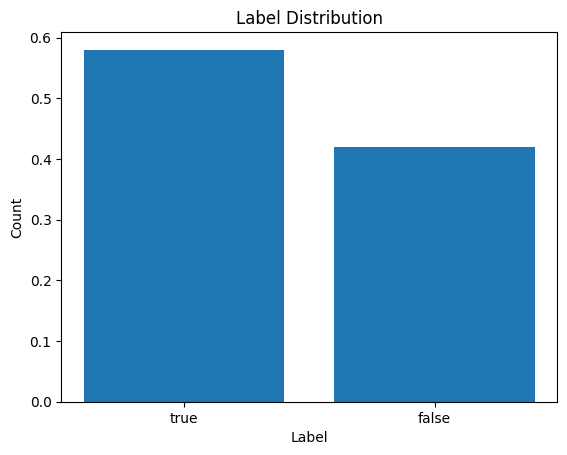

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.bar(final_data['label'].value_counts().index, final_data['label'].value_counts(normalize=True).values)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.savefig('label_distribution.png')
plt.show()

## DATA CLEANING

In [32]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(cleaned_tokens)

final_data['clean_claim'] = final_data['claim'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## AVERAGE LENGTH OF POST/CLAIM

In [33]:
def average_words_per_text(texts):
    lengths = [len(str(text).split()) for text in texts]
    return sum(lengths) / len(lengths) if lengths else 0

avg_words = average_words_per_text(final_data["clean_claim"])
print(f"Average words per post: {avg_words:.2f}")

Average words per post: 12.30


## TOP COMMON WORDS

In [34]:
from collections import Counter
import re

def get_top_words_by_label(texts, labels, top_n=20):

    true_counter = Counter()
    false_counter = Counter()

    for text, label in zip(texts, labels):
        words = clean_text(text).split()
        if label.lower() == "true":
            true_counter.update(words)
        elif label.lower() == "false":
            false_counter.update(words)

    return true_counter.most_common(top_n), false_counter.most_common(top_n)

top_true, top_false = get_top_words_by_label(final_data['clean_claim'].tolist(), final_data['label'].tolist())

print("Top words in TRUE claims:")
print(top_true)

print("\nTop words in FALSE claims:")
print(top_false)

Top words in TRUE claims:
[('covid19', 2202), ('case', 2038), ('new', 1282), ('test', 963), ('state', 949), ('death', 879), ('coronavirus', 742), ('number', 690), ('health', 686), ('people', 575), ('u', 567), ('total', 504), ('report', 495), ('say', 477), ('reported', 471), ('confirmed', 467), ('day', 447), ('testing', 447), ('amp', 412), ('study', 408)]

Top words in FALSE claims:
[('coronavirus', 1416), ('covid19', 1334), ('say', 620), ('new', 480), ('people', 463), ('trump', 380), ('u', 342), ('show', 336), ('health', 329), ('president', 324), ('vaccine', 321), ('virus', 297), ('claim', 291), ('death', 288), ('pandemic', 268), ('state', 267), ('case', 256), ('video', 253), ('test', 246), ('patient', 241)]


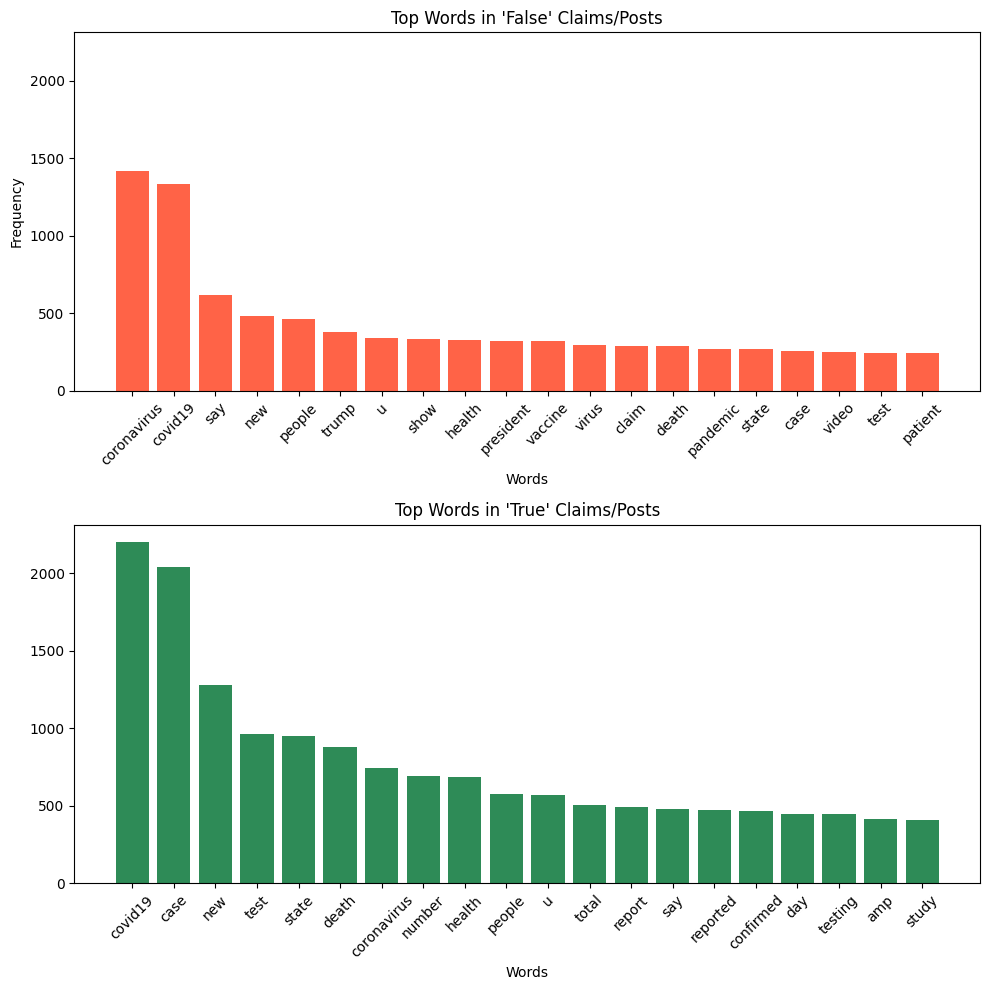

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_words_dual_subplot(top_words_false, top_words_true):
    words_false, counts_false = zip(*top_words_false)
    words_true, counts_true = zip(*top_words_true)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

    # False
    axes[0].bar(words_false, counts_false, color='tomato')
    axes[0].set_title("Top Words in 'False' Claims/Posts")
    axes[0].set_xlabel("Words")
    axes[0].set_ylabel("Frequency")
    axes[0].tick_params(axis='x', rotation=45)

    # True
    axes[1].bar(words_true, counts_true, color='seagreen')
    axes[1].set_title("Top Words in 'True' Claims/Posts")
    axes[1].set_xlabel("Words")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig("top_words_true_vs_false.png")
    plt.show()

plot_top_words_dual_subplot(top_false, top_true)

# Baseline models

In [36]:
X = final_data['clean_claim']
y = final_data['label'].map({'true': 1, 'false': 0})

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

## Naive Bayes

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# naive bayes
modelNB = MultinomialNB()
modelNB.fit(X_train, y_train)


y_pred_nb = modelNB.predict(X_test)


print(classification_report(y_test, y_pred_nb, target_names=["False", "True"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

              precision    recall  f1-score   support

       False       0.80      0.60      0.68      1294
        True       0.76      0.89      0.82      1846

    accuracy                           0.77      3140
   macro avg       0.78      0.75      0.75      3140
weighted avg       0.78      0.77      0.77      3140

Confusion Matrix:
 [[ 777  517]
 [ 199 1647]]


## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

# logistic regression
modelLR = LogisticRegression(max_iter=1000)
modelLR.fit(X_train, y_train)

y_pred_lr = modelLR.predict(X_test)

print(classification_report(y_test, y_pred_lr, target_names=["False", "True"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

       False       0.78      0.66      0.71      1294
        True       0.78      0.87      0.82      1846

    accuracy                           0.78      3140
   macro avg       0.78      0.76      0.77      3140
weighted avg       0.78      0.78      0.78      3140

Confusion Matrix:
 [[ 848  446]
 [ 238 1608]]


## Evaluation plots

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def plot_evaluation(y_true, y_pred_nb, y_pred_lr):
    report_nb = classification_report(y_true, y_pred_nb, output_dict=True, zero_division=0, target_names=["False", "True"])
    report_lr = classification_report(y_true, y_pred_lr, output_dict=True, zero_division=0, target_names=["False", "True"])

    df_nb = pd.DataFrame(report_nb).transpose().loc[['False', 'True'], ['precision', 'recall', 'f1-score']]
    df_nb['model'] = 'Naive Bayes'

    df_lr = pd.DataFrame(report_lr).transpose().loc[['False', 'True'], ['precision', 'recall', 'f1-score']]
    df_lr['model'] = 'Logistic Regression'

    df_all = pd.concat([df_nb, df_lr]).reset_index().rename(columns={'index': 'label'})

    # 🎯 plot F1
    plt.figure(figsize=(7, 5))
    sns.barplot(data=df_all, x='label', y='f1-score', hue='model', width=0.6)
    plt.title('F1 Score per Label')
    plt.xlabel('Label')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("f1_score_comparison.png")
    plt.show()

    # 🎯 confusion matrix - naive bayes
    cm_nb = confusion_matrix(y_true, y_pred_nb)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title('Confusion Matrix - Naive Bayes')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig("confusion_naive_bayes.png")
    plt.show()

    # 🎯 confusion matrix - naive bayes
    cm_lr = confusion_matrix(y_true, y_pred_lr)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title('Confusion Matrix - Logistic Regression')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig("confusion_matrix_logistic.png")
    plt.show()


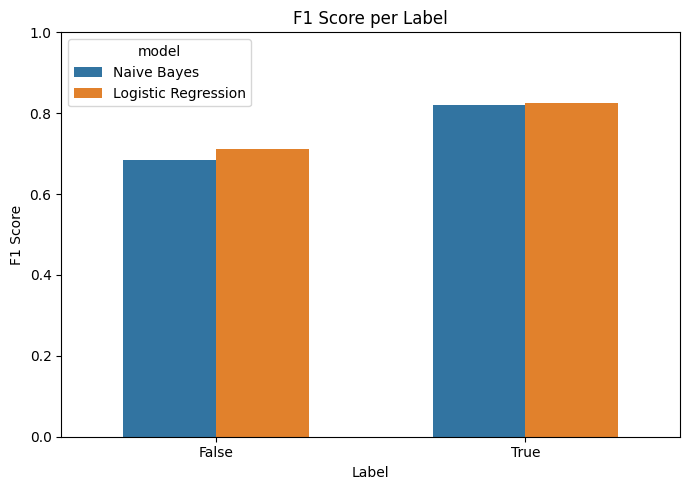

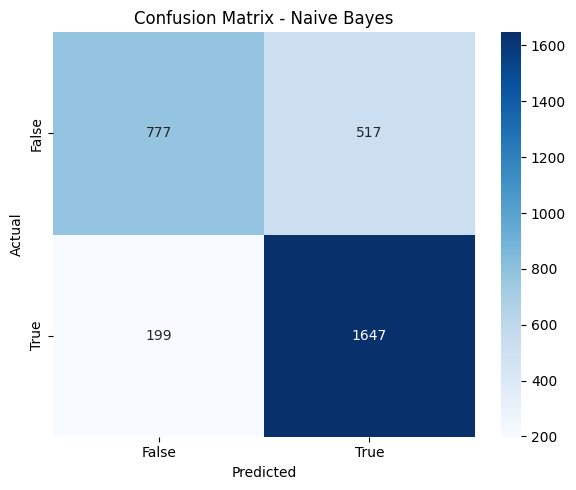

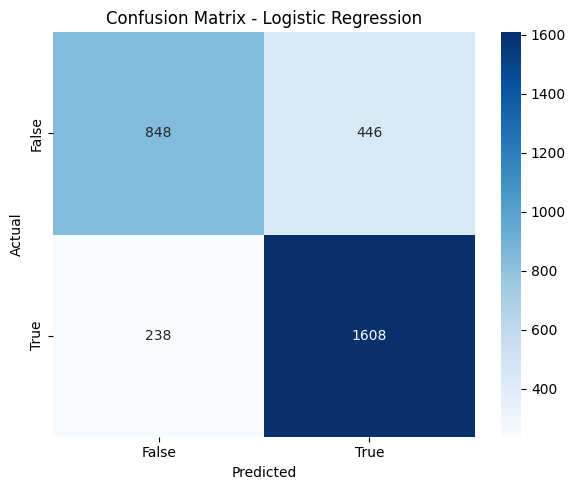

In [41]:
plot_evaluation(y_test, y_pred_nb, y_pred_lr)